In [2]:
import tarfile
import os
import pandas as pd
import numpy as np
os.getcwd()

'C:\\Users\\User\\Downloads\\Sentiment analysis'

##  Twitter Sentiment Analysis with RNN and CNN 
Coded by Soumonos Mukherjee

##  Read data

In [4]:
tarfile.open("tp_sentiment_analysis.tar.gz").extractall()

##  Load and process data.

In [5]:
header_list= ["id","ho","timestamp","feedback","label","company"]
df_raw= pd.read_csv("sanders-twitter-sentiment.csv",names=header_list)
df_raw.head()

,id,ho,timestamp,feedback,label,company
0,1044,125667332931596290,2011-10-16 20:20:01,&quot;3 principal global players will be activ...,neutral,apple
1,71,126384526925639681,2011-10-18 19:49:53,"If you've been struggling to get hold of me, I...",neutral,apple
2,278,126281019476291585,2011-10-18 12:58:35,"@azee1v1 @apple @umber Proper consolidation, p...",negative,apple
3,5743,126862268725080065,2011-10-20 03:28:16,me acabo de dar cuenta q tengo mas seguidores ...,irrelevant,twitter
4,510,126054725727698944,2011-10-17 21:59:23,"With Siri, Apple Could Eventually Build A Real...",neutral,apple


For preprocessing the tweets, we have written a module. We will import that

In [6]:
import preprocess_twitter

In [7]:
preprocessed_feedback= [preprocess_twitter.preprocess(i) for i in df_raw.feedback]

In [8]:
preprocessed_feedback[1:10]

["if you've been struggling to get hold of me, i'm back online with a new iphone - thanks <user>",
 '<user> <user> <user> proper consolidation, proper syncing, stop losing my purchased items, checkboxes that do what you think they will do.',
 'me acabo de dar cuenta q tengo mas seguidores en <hashtag>  twitter <smile> gracias y espero q sigan sumandoo mas y mas <smile> para seguir aun mas activo aki',
 'with siri, apple could eventually build a real ai <url>  + <user> <hashtag>  apple <hashtag>  siri',
 'all this talk about about how good <hashtag> icecreamsandwich looks is making me hungry <hashtag> google <hashtag> omnomnomnom',
 '<hashtag>  galaxy nexus es presentado oficialmente. <url> | conoce los detalles del nuevo telã©fono de <hashtag>  google',
 "rt <user>: <hashtag> twitter; for those statuses you'd never post on <hashtag> facebook",
 'one serious statement tho !  <hashtag>  twitter blocked the <hashtag>  troy davis <hashtag> tt <allcaps>  <hashtag>  twitter was cool w <hasht

In [9]:
from sklearn.preprocessing import OneHotEncoder

In [10]:
# Preprocessing of labels with encoding
labels= df_raw['label']
from keras.utils.np_utils import to_categorical
import numpy as np
label_mapping={'positive': 0, 'negative': 1,'neutral': 2, 'irrelevant': 3}

label=to_categorical(labels.map(label_mapping))

label.shape
label[1:10]

Using TensorFlow backend.


array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

##  Vectorizing the preprocessed tweets

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [12]:
def vectorize(text,ml):
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    data = pad_sequences(sequences, maxlen=ml)
    vocab = tokenizer.word_index
    vocab['<eos>'] = 0
    return data,vocab

In [13]:
feedback_vectorized,vocabfv= vectorize(preprocessed_feedback,32)

In [14]:
feedback_vectorized.shape

(5513, 32)

In [15]:
label.shape

(5513, 4)

In [16]:
#Train and test dataset splitting 
x_train= feedback_vectorized[:4000]
x_test= feedback_vectorized[4000:]
y_train= label[:4000]
y_test= label[4000:]

## Train and evaluate the model

In [17]:
#Changed the encoding type to "utf8"
import embedding1

We use a pretrained word-embedding model 

In [18]:
weights_feedbacks= embedding1.load(vocabfv,100,'glove.twitter.27B.100d.filtered.txt')

loading embeddings from "glove.twitter.27B.100d.filtered.txt"


## Use RNN to train the first classifier:

In [19]:
from keras.layers import Embedding, Input, GRU, Dense
from keras.models import Model
from matplotlib import pyplot

Defining the precision, recall and f1 score metrics

In [20]:
from keras import backend as K
def recall_m(yval_s, y_pred):
    true_positives = K.sum(K.round(K.clip(yval_s * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(yval_s, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(yval_s, y_pred):
    true_positives = K.sum(K.round(K.clip(yval_s * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(yval_s, y_pred):
    precision = precision_m(yval_s, y_pred)
    recall = recall_m(yval_s, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Defining and training the RNN with GRU


Train on 4000 samples, validate on 1513 samples
Epoch 1/15
4000/4000 [==============================] - 12s 3ms/step - loss: 0.8789 - acc: 0.6570 - f1_m: 0.5868 - precision_m: 0.7128 - recall_m: 0.5176 - val_loss: 0.7284 - val_acc: 0.7065 - val_f1_m: 0.6959 - val_precision_m: 0.7456 - val_recall_m: 0.6529
Epoch 2/15
4000/4000 [==============================] - 9s 2ms/step - loss: 0.6641 - acc: 0.7450 - f1_m: 0.7293 - precision_m: 0.7907 - recall_m: 0.6783 - val_loss: 0.7334 - val_acc: 0.7098 - val_f1_m: 0.6907 - val_precision_m: 0.7734 - val_recall_m: 0.6253
Epoch 3/15
4000/4000 [==============================] - 8s 2ms/step - loss: 0.6030 - acc: 0.7703 - f1_m: 0.7590 - precision_m: 0.8167 - recall_m: 0.7098 - val_loss: 0.6425 - val_acc: 0.7442 - val_f1_m: 0.7331 - val_precision_m: 0.8075 - val_recall_m: 0.6727
Epoch 4/15
4000/4000 [==============================] - 9s 2ms/step - loss: 0.5424 - acc: 0.7955 - f1_m: 0.7894 - precision_m: 0.8350 - recall_m: 0.7498 - val_loss: 0.6381 - va

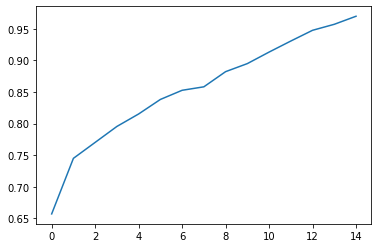

In [21]:
embedding_layer = Embedding(len(vocabfv), 100, weights=[weights_feedbacks],input_length=32, trainable=False)
sequence_input = Input(shape=(32,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = GRU(64)(embedded_sequences)
preds = Dense(label.shape[1], activation='softmax')(x)
modelrnn = Model(sequence_input, preds)
modelrnn.compile(loss='categorical_crossentropy',optimizer='Nadam', metrics=['acc',f1_m,precision_m, recall_m])
trained= modelrnn.fit(x_train, y_train,epochs=15,validation_data=(x_test,y_test), batch_size=64, shuffle=True)
pyplot.plot(trained.history['acc'])
pyplot.show()


Q2: evaluate the model using precision, recall, F1-measure, and accuracy metrics.

In [22]:
categorical_crossentropy_lossr, accuracyr, f1_scorer, precisionr, recallr = modelrnn.evaluate(x_test, y_test, verbose=0)

In [23]:
categorical_crossentropy_lossr, accuracyr, f1_scorer, precisionr, recallr

(0.8165182862467744,
 0.7799074649810791,
 0.778437614440918,
 0.7865169644355774,
 0.7707610130310059)

## Training CNN with the same

In [24]:
from keras.layers import Conv1D, MaxPooling1D, Flatten


Train on 4000 samples, validate on 1513 samples
Epoch 1/10
4000/4000 [==============================] - 3s 872us/step - loss: 0.8193 - acc: 0.6800 - f1_m: 0.6403 - precision_m: 0.7296 - recall_m: 0.5781 - val_loss: 0.7216 - val_acc: 0.7145 - val_f1_m: 0.7012 - val_precision_m: 0.7746 - val_recall_m: 0.6415
Epoch 2/10
4000/4000 [==============================] - 2s 509us/step - loss: 0.5707 - acc: 0.7803 - f1_m: 0.7726 - precision_m: 0.8378 - recall_m: 0.7192 - val_loss: 0.8307 - val_acc: 0.6946 - val_f1_m: 0.6938 - val_precision_m: 0.7060 - val_recall_m: 0.6821
Epoch 3/10
4000/4000 [==============================] - 2s 436us/step - loss: 0.4477 - acc: 0.8395 - f1_m: 0.8311 - precision_m: 0.8779 - recall_m: 0.7897 - val_loss: 0.6751 - val_acc: 0.7482 - val_f1_m: 0.7328 - val_precision_m: 0.7873 - val_recall_m: 0.6862
Epoch 4/10
4000/4000 [==============================] - 2s 541us/step - loss: 0.3432 - acc: 0.8878 - f1_m: 0.8810 - precision_m: 0.9147 - recall_m: 0.8504 - val_loss: 0.67

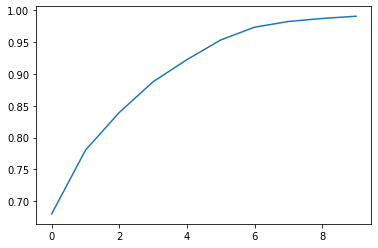

In [25]:
sequence_input = Input(shape=(32,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 3, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x) # global max pooling
x = Flatten()(x)
preds = Dense(label.shape[1], activation='softmax')(x)

modelcnn = Model(sequence_input, preds)
modelcnn.compile(loss='categorical_crossentropy',optimizer='Nadam', metrics=['acc',f1_m,precision_m, recall_m])
trained1= modelcnn.fit(x_train, y_train,epochs=10,validation_data=(x_test,y_test), batch_size=64, shuffle=True)
pyplot.plot(trained1.history['acc'])
pyplot.show()

Q2: evaluate the model using precision, recall, F1-measure, and accuracy metrics.

In [26]:
categorical_crossentropy_lossc, accuracyc, f1_scorec, precisionc, recallc = modelcnn.evaluate(x_test, y_test, verbose=0)

In [27]:
categorical_crossentropy_lossc, accuracyc, f1_scorec, precisionc, recallc

(0.8678297041783014,
 0.7521480321884155,
 0.7538431286811829,
 0.766848087310791,
 0.7418258190155029)

RNN performs better but is more expensive in terms of time complexity 